In [21]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report
from baal.active import get_heuristic
from baal.active.active_loop import ActiveLearningLoop
from baal.active.dataset.nlp_datasets import active_huggingface_dataset, HuggingFaceDatasets
from baal.bayesian.dropout import patch_module
from baal.transformers_trainer_wrapper import BaalTransformersTrainer
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=1,  # change this if it is taking too long on your computer
) 

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/

In [24]:
def calculate(a):
    rotated = list(zip(*a[::-1]))
    median0 = []
    min0 = []
    max0 = []
    for i in range(len(rotated)):
        median0.append(np.median(rotated[i]))
        min0.append(np.min(rotated[i]))
        max0.append(np.max(rotated[i]))
    return median0,min0,max0

In [25]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_abortion)} instances loaded")

val_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_abortion)} instances loaded")

test_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_abortion)} instances loaded")

num_classes = np.unique(train_dataset_abortion['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 587 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 66 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 280 instances loaded


In [26]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [27]:
al_epochs=30
n_labeled_examples = np.unique(train_dataset_abortion['text']).size
training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
print(training_indices0)
active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
# # lets randomly label 100 samples, therefore len(active_set) should be 100
active_set_abortion.can_label = False
active_set_abortion.label(training_indices0)
from baal.active import get_heuristic
heuristic = get_heuristic('certainty')
model = patch_module(model_original)
init_weights = deepcopy(model.state_dict())

def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
model.train()
unqueried_score=model.evaluate()['eval_accuracy']
performance_history_abortion=[unqueried_score]
for epoch in range(al_epochs):
    model.train()
    eval_metrics = model.evaluate()
    should_continue = active_loop_abortion.step()
    model.load_state_dict(init_weights)
    model.lr_scheduler = None
    if not should_continue:
            break
    active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
    }

    logs = {**eval_metrics, **active_logs}
    performance_history_abortion.append(eval_metrics['eval_accuracy'])

[535  69 215]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:18.747764Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 30.58it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:23.109288Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.16it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:27.593145Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.32it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:32.286183Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 31.76it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:37.320342Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.70it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:42.688482Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.10it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:48.114005Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.12it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:54.130576Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 31.89it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:56:59.759122Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.41it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:05.940233Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 30.78it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:12.067204Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.74it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:17.985739Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 32.83it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:24.244249Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.05it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:30.575770Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 31.83it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:37.353767Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.93it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:44.656939Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.54it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:52.134158Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 31.46it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:57:59.742291Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.44it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:58:07.613607Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.45it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:58:15.885607Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.52it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:58:23.905176Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.42it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:58:32.370230Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:58:40.570842Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 31.47it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:58:49.020365Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.47it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:58:57.952634Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 29.75it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:59:07.071745Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:59:16.311324Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.52it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:59:25.576805Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.29it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:59:34.641012Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[4776-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-11T01:59:43.734842Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.64it/s]


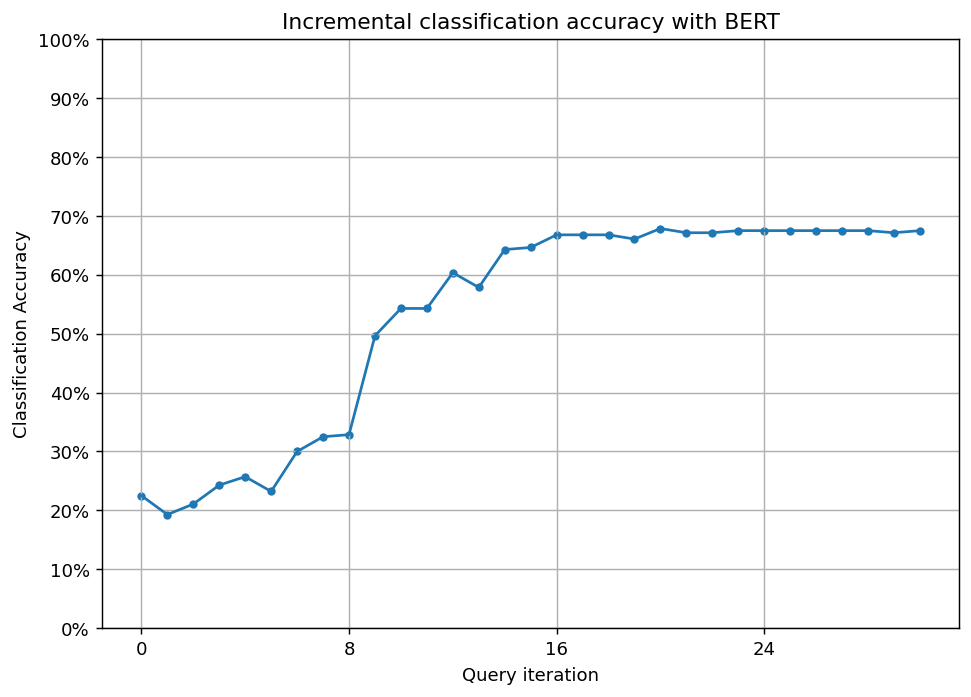

In [30]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_abortion)
ax.scatter(range(len(performance_history_abortion)), performance_history_abortion, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy with BERT')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [31]:
fig.savefig('BERT_fig.jpg')